# ATAC-seq analysis in R


In this tutorial, we go over how to use scvi-tools functionality in R for analyzing ATAC-seq data. We will closely follow the PBMC tutorial from [Signac](https://satijalab.org/signac/articles/pbmc_vignette.html), using scvi-tools when appropriate.

This tutorial requires Reticulate. Please check out our installation [guide](https://www.scvi-tools.org/en/latest/installation.html#scvi-tools-installation-for-R) for instructions on installing Reticulate and scvi-tools.

## Loading and processing data with Signac

In [2]:
system("wget https://cf.10xgenomics.com/samples/cell-atac/1.0.1/atac_v1_pbmc_10k/atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5")
system("wget https://cf.10xgenomics.com/samples/cell-atac/1.0.1/atac_v1_pbmc_10k/atac_v1_pbmc_10k_singlecell.csv")
system("wget https://cf.10xgenomics.com/samples/cell-atac/1.0.1/atac_v1_pbmc_10k/atac_v1_pbmc_10k_fragments.tsv.gz")
system("wget https://cf.10xgenomics.com/samples/cell-atac/1.0.1/atac_v1_pbmc_10k/atac_v1_pbmc_10k_fragments.tsv.gz.tbi")

In [1]:
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)

Attaching SeuratObject

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: ensembldb

Loading required package: GenomicRanges

Loading required package: GenomicFeatures

Loading required p

## Pre-processing

We follow the original tutorial to create the Seurat object with ATAC data.

In [2]:
counts <- Read10X_h5(filename = "atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5")
metadata <- read.csv(
  file = "atac_v1_pbmc_10k_singlecell.csv",
  header = TRUE,
  row.names = 1
)

chrom_assay <- CreateChromatinAssay(
  counts = counts,
  sep = c(":", "-"),
  genome = 'hg19',
  fragments = 'atac_v1_pbmc_10k_fragments.tsv.gz',
  min.cells = 10,
  min.features = 200
)

pbmc <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata
)

Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Computing hash

Warning message in CreateSeuratObject.Assay(counts = chrom_assay, assay = "peaks", :
"Some cells in meta.data not present in provided counts matrix."


In [3]:
pbmc

An object of class Seurat 
87561 features across 8728 samples within 1 assay 
Active assay: peaks (87561 features, 0 variable features)

In [4]:
pbmc[['peaks']]

ChromatinAssay data with 87561 features for 8728 cells
Variable features: 0 
Genome: hg19 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 1 

We add gene annotation information to facilitate downstream functionality.

In [5]:
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v75)

# change to UCSC style since the data was mapped to hg19
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- "hg19"

# add the gene information to the object
Annotation(pbmc) <- annotations

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

## Computing QC metrics

We compute the same QC metrics as the [original tutorial](https://satijalab.org/signac/articles/pbmc_vignette.html#computing-qc-metrics-1). We leave it to the reader to follow the excellent Signac tutorial for understanding what these quantities represent.

In [6]:
# compute nucleosome signal score per cell
pbmc <- NucleosomeSignal(object = pbmc)

# compute TSS enrichment score per cell
pbmc <- TSSEnrichment(object = pbmc, fast = FALSE)

# add blacklist ratio and fraction of reads in peaks
pbmc$pct_reads_in_peaks <- pbmc$peak_region_fragments / pbmc$passed_filters * 100
pbmc$blacklist_ratio <- pbmc$blacklist_region_fragments / pbmc$peak_region_fragments

Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



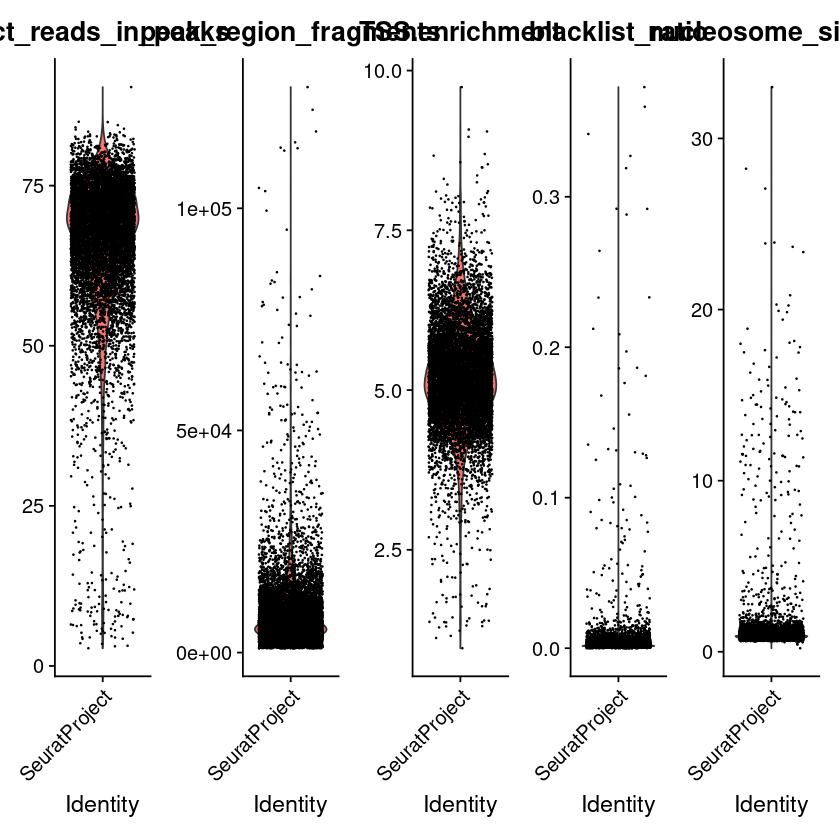

In [7]:
VlnPlot(
  object = pbmc,
  features = c('pct_reads_in_peaks', 'peak_region_fragments',
               'TSS.enrichment', 'blacklist_ratio', 'nucleosome_signal'),
  pt.size = 0.1,
  ncol = 5
)

In [8]:
pbmc <- subset(
  x = pbmc,
  subset = peak_region_fragments > 3000 &
    peak_region_fragments < 20000 &
    pct_reads_in_peaks > 15 &
    blacklist_ratio < 0.05 &
    nucleosome_signal < 4 &
    TSS.enrichment > 2
)
pbmc

An object of class Seurat 
87561 features across 7060 samples within 1 assay 
Active assay: peaks (87561 features, 0 variable features)

## Using PeakVI for dimensionality reduction and imputation


### Creating an AnnData object

We follow the standard workflow for converting between Seurat and AnnData.

In [9]:
library(reticulate)
library(sceasy)
use_python("/home/adam/.pyenv/versions/3.9.7/bin/python", required = TRUE)
sc <- import("scanpy", convert = FALSE)
scvi <- import("scvi", convert = FALSE)

In [10]:
adata <- convertFormat(pbmc, from="seurat", to="anndata", main_layer="counts", assay="peaks", drop_single_values=FALSE)
print(adata) # Note generally in Python, dataset conventions are obs x var

AnnData object with n_obs × n_vars = 7060 × 87561
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pct_reads_in_peaks', 'blacklist_ratio'
    var: 'count', 'percentile'


### Run the standard PeakVI workflow

In [13]:
scvi$data$setup_anndata(adata)

None

In [15]:
pvi <- scvi$model$PEAKVI(adata)
pvi$train()

None

In [27]:
# get the latent represenation
latent = pvi$get_latent_representation()

# put it back in our original Seurat object
latent <- as.matrix(latent)
rownames(latent) = colnames(pbmc)
ndims <- ncol(latent)
pbmc[["peakvi"]] <- CreateDimReducObject(embeddings = latent, key = "peakvi_", assay = "peaks")

Warning message:
"No columnames present in cell embeddings, setting to 'peakvi_1:17'"


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7060
Number of edges: 223250

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8588
Number of communities: 19
Elapsed time: 0 seconds


13:23:09 UMAP embedding parameters a = 0.9922 b = 1.112

13:23:09 Read 7060 rows and found 17 numeric columns

13:23:09 Using Annoy for neighbor search, n_neighbors = 30

13:23:09 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:23:09 Writing NN index file to temp file /tmp/RtmpGPuyJe/file1ffb78f17b8e

13:23:09 Searching Annoy index using 1 thread, search_k = 3000

13:23:10 Annoy recall = 100%

13:23:11 Commencing smooth kNN distance calibration using 1 thread

13:23:13 Initializing from normalized Laplacian + noise

13:23:13 Commencing optimization for 500 epochs, with 279596 positive edges

13:23:19 Optimization finished



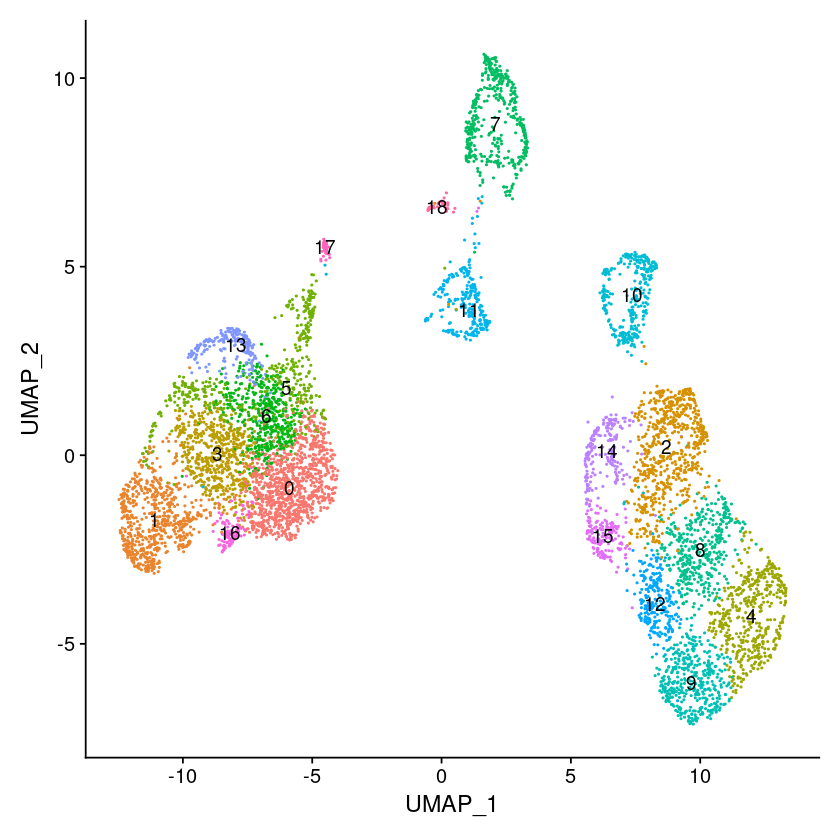

In [31]:
# Find clusters, then run UMAP, and visualize
pbmc <- FindNeighbors(pbmc, reduction = "peakvi", dims=1:ndims)
pbmc <- FindClusters(pbmc, resolution = 1)

pbmc <- RunUMAP(pbmc, reduction = "peakvi", dims=1:ndims)

DimPlot(object = pbmc, label = TRUE) + NoLegend()

## Finding differentially accessible peaks between clusters

As PeakVI learns uncertainty around the observed data, it can be leveraged for differential accessibility analysis. First, let's store the seurat cluster information back inside the AnnData.

In [32]:
adata$obs$insert(adata$obs$shape[1], "seurat_clusters", pbmc[["seurat_clusters"]][,1])

None

Using our trained PEAKVI model, we call the `differential_accessibility()` method
We pass `seurat_clusters` to the groupby argument and compare between cluster `0` and cluster `9`.

The output of DE is a DataFrame with the bayes factors. Bayes factors > 3 have high probability of being differentially expressed. You can also set fdr_target, which will return the differentially expressed genes based on the posteior expected FDR. 

In [44]:
DA <- pvi$differential_accessibility(adata, groupby="seurat_clusters", group1 = "0", group2 = "9")
DA <- py_to_r(DA)
head(DA)

,prob_da,is_da_fdr,bayes_factor,effect_size,emp_effect,est_prob1,est_prob2,emp_prob1,emp_prob2
,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1-565107-565550,0.0000,FALSE,-18.4206808,0.01366626,0.00194426,0.012670633,0.026336893,0.002994012,0.004938272
chr1-569174-569639,0.3484,FALSE,-0.6260796,0.04752485,0.01476307,0.012242876,0.059767731,0.004990020,0.019753086
chr1-713460-714823,0.9986,TRUE,6.5698749,0.23666367,0.11933171,0.386590749,0.623254418,0.159680639,0.279012346
chr1-752422-753038,1.0000,TRUE,18.4206808,-0.18127349,-0.07285429,0.188162908,0.006889422,0.072854291,0.000000000
chr1-762106-763359,0.6182,FALSE,0.4819151,0.05572331,0.05160790,0.300330877,0.356054187,0.118762475,0.170370370
chr1-779589-780271,0.4542,FALSE,-0.1837150,0.05026080,0.02316848,0.005918491,0.056179293,0.003992016,0.027160494


In [55]:
# sort by proba_da and effect_size
DA <- DA[order(-DA[, 1], -DA[, 4]), ]
head(DA)

,prob_da,is_da_fdr,bayes_factor,effect_size,emp_effect,est_prob1,est_prob2,emp_prob1,emp_prob2
,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr14-99721608-99741934,1,TRUE,18.42068,0.9657446,0.7347010,0.026577087,0.9923217,0.010978044,0.7456790
chr14-99695477-99720910,1,TRUE,18.42068,0.9518369,0.6023139,0.035298262,0.9871352,0.014970060,0.6172840
chr1-60279767-60281364,1,TRUE,18.42068,0.9414349,0.4957197,0.016968131,0.9584031,0.007984032,0.5037037
chr17-80084198-80086094,1,TRUE,18.42068,0.9403957,0.4898351,0.008447577,0.9488432,0.003992016,0.4938272
chr7-142501666-142511108,1,TRUE,18.42068,0.9326039,0.5428476,0.057816163,0.9904200,0.034930140,0.5777778
chr11-128334097-128348572,1,TRUE,18.42068,0.9156649,0.4788571,0.028879821,0.9445447,0.014970060,0.4938272


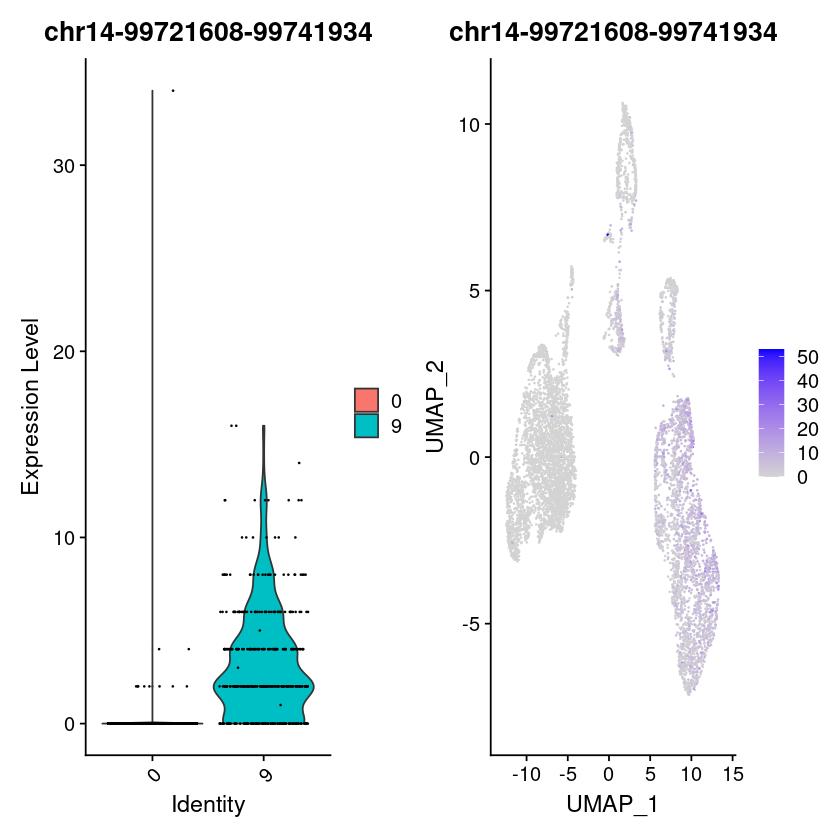

In [59]:
plot1 <- VlnPlot(
  object = pbmc,
  features = rownames(DA)[1],
  pt.size = 0.1,
  idents = c("0","9")
)
plot2 <- FeaturePlot(
  object = pbmc,
  features = rownames(DA)[1],
  pt.size = 0.1
)

plot1 | plot2

In [57]:
sI <- sessionInfo()
sI$loadedOnly <- NULL
print(sI, locale=FALSE)

R version 4.1.0 (2021-05-18)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] sceasy_0.0.6              reticulate_1.20          
 [3] patchwork_1.1.1           ggplot2_3.3.5            
 [5] EnsDb.Hsapiens.v75_2.99.0 ensembldb_2.17.4         
 [7] AnnotationFilter_1.17.1   GenomicFeatures_1.45.2   
 [9] AnnotationDbi_1.55.1      Biobase_2.53.0           
[11] GenomicRanges_1.45.0      GenomeInfoDb_1.29.8      
[13] IRanges_2.27.2            S4Vectors_0.31.3         
[15] BiocGenerics_0.39.2       SeuratObject_4.0.2       
[17] Seurat_4.0.4              Signac_1.3.0             
